# Delay Scan -  DESC fringes on ExitScreen

In [1]:
import h5py;
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import Image
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

**DAQ run with delay scan**

In [2]:
runNumber = 28496

dataDir = '/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/'
hdfFilename = 'FLASH1_USER1-run'+str(runNumber)+'.h5'
imagePath = '/asap3/flash/gpfs/bl1/2017/data/11003895/processed/notebooks/fig/'

print(dataDir+hdfFilename)

/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/FLASH1_USER1-run28496.h5


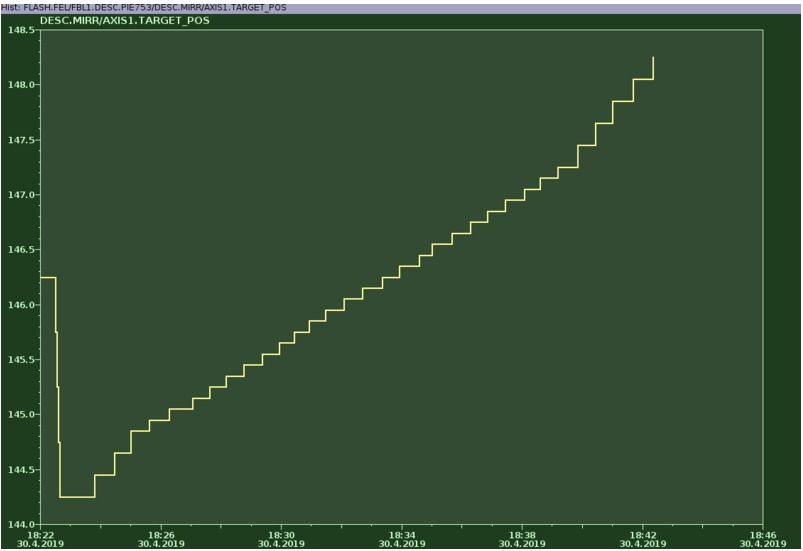

In [3]:
Image("delaymotor_history.jpeg")

### Read and Plot Delay Stage Positions

In [4]:
hdfFile = h5py.File(dataDir+hdfFilename,'r')
motorPosFine = hdfFile['/FL1/Experiment/BL1/CAMP/DESC/Fine delay stage/position'].value
motorPosCoarse = hdfFile['/FL1/Experiment/BL1/CAMP/DESC/Coarse delay stage/position'].value

/software/anaconda3/5.2/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


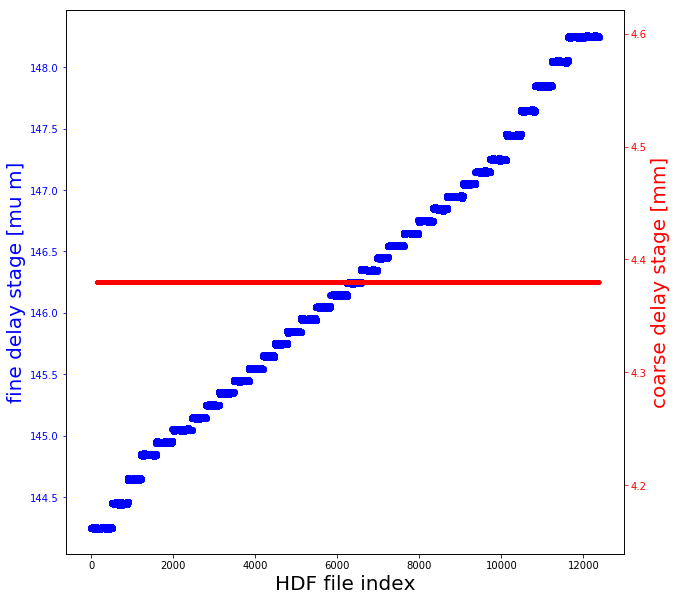

In [5]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.plot(motorPosFine,'bo')
ax1.set_xlabel('HDF file index',fontsize=20)
ax1.set_ylabel('fine delay stage [mu m]', color='b', fontsize=20)
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(motorPosCoarse,'r.')
ax2.set_ylabel('coarse delay stage [mm]', color='r', fontsize=20)
ax2.tick_params('y', colors='r')

plt.show()

### Check Motor Positions for NaNs

In [6]:
def countNaNs(array):
    return np.count_nonzero(np.isnan(array))   

print('Number of NaNs inf Fine Delay Stage:', countNaNs(motorPosFine))
print('Number of NaNs inf Coarse Delay Stage:', countNaNs(motorPosCoarse))

Number of NaNs inf Fine Delay Stage: 831
Number of NaNs inf Coarse Delay Stage: 963


### Calculate Time Delay between Pump and Probe Beam

$$  \Delta t = \Delta z (1 + \cos(\alpha)) / c     $$ 

with

$$ \Delta z = z_{\text{long}} - 4.38 \text{mm} + z_{\text{short}} - 125.65 \mu \text{m}  $$
$$ \alpha = 0.7 ^\circ $$

Ref.: https://doi.org/10.1107/S1600577518006094

transpose timeDelay in femto seconds 

NaNs: 963 out of 13200 data points


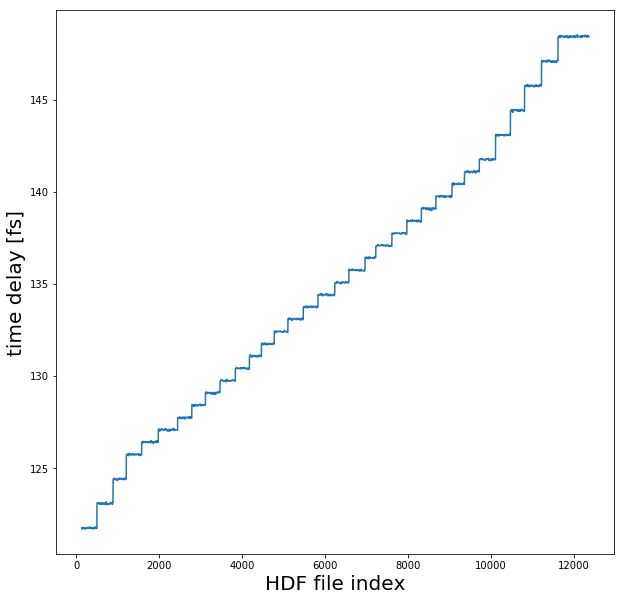

In [7]:
timeDelay = (motorPosFine/1000000+motorPosCoarse/1000-0.00438-0.000126)*(1+np.cos(0.7*np.pi/180))/299792458
print('NaNs: {} out of {} data points'.format(countNaNs(timeDelay),timeDelay.shape[0]))

timeDelay = timeDelay*1E15

fig = plt.figure(figsize=(10,10))
plt.plot( timeDelay)
plt.xlabel('HDF file index', fontsize=20)
plt.ylabel('time delay [fs]', fontsize=20)
plt.show()

### Find Delay Steps

Number of Delay Steps:  33
[498, 887, 1206, 1577, 1978, 2445, 2787, 3115, 3468, 3837, 4176, 4466, 4776, 5105, 5475, 5830, 6235, 6576, 6965, 7225, 7613, 7974, 8324, 8673, 9064, 9364, 9722, 10113, 10472, 10813, 11222, 11620]


/software/anaconda3/5.2/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


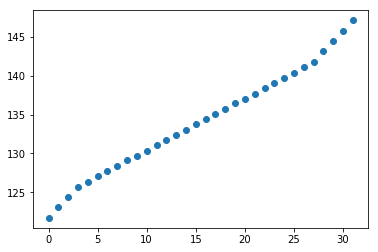

In [8]:
timeDelayTreshold = 0.5 # in fs

resDelay = np.asarray([x -y for x,y in zip(timeDelay, timeDelay[1:])])
resDelay = np.append(resDelay,0)
changeDelay = ( np.abs(resDelay) > timeDelayTreshold)
print('Number of Delay Steps: ',np.count_nonzero(changeDelay) +1 )

indexDelayChange = [i for i, val in enumerate(changeDelay) if val] 
print(indexDelayChange)

plt.plot(timeDelay[indexDelayChange],'o')
plt.show()

## Read Images from h5 file 

In [9]:
hdfFile = h5py.File(dataDir+hdfFilename,'r')
img = hdfFile['/uncategorised/FLASH1_USER1/FLASH.FEL/FBL1.CAM/EXIT_SCREEN/dset'].value
print(type(img),'|',img.shape)

/software/anaconda3/5.2/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


<class 'numpy.ndarray'> | (13200, 1280, 960)


### Define ROI and Calculate Integral of ROI for all Images

In [10]:
ROI_x1, ROI_y1 = 200, 100
ROI_x2, ROI_y2 = 700, 700

integral = np.asarray([np.sum(img[index][ROI_x1:ROI_x2,ROI_y1:ROI_y2]) for index in range(0,img.shape[0])])

### Plot Degree of Exposure & Delay Steps

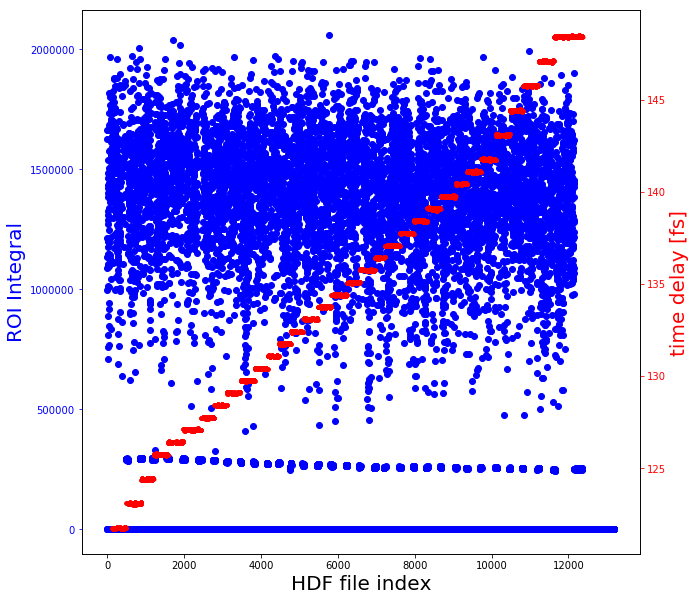

In [11]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.plot(integral,'bo')
ax1.set_xlabel('HDF file index',fontsize=20)
ax1.set_ylabel('ROI Integral', color='b', fontsize=20)
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(timeDelay,'r.')
ax2.set_ylabel('time delay [fs]', color='r', fontsize=20)
ax2.tick_params('y', colors='r')

plt.show()

* We see that we have 3 types of images: real images (fringes), dark images (blocked shutter) & zeros (DAQ drops)
* 33 delay steps 
* drift in darks? 

### Zooming In

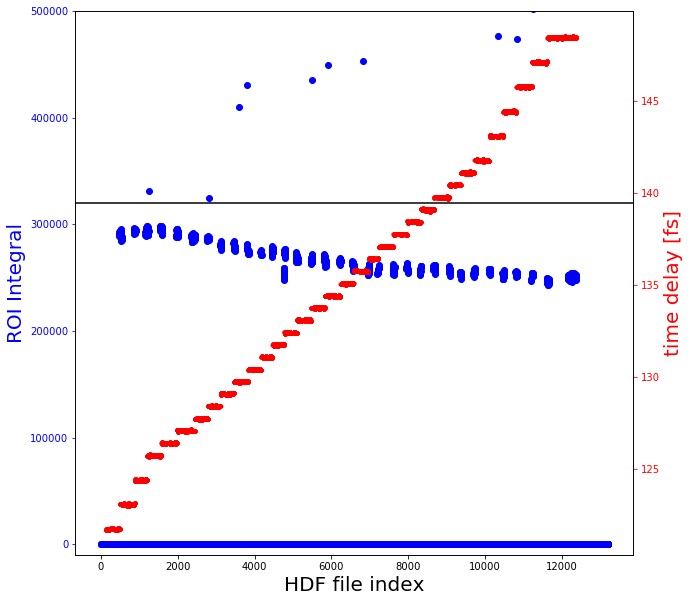

In [12]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.plot(integral,'bo')
ax1.set_xlabel('HDF file index',fontsize=20)
ax1.set_ylabel('ROI Integral', color='b', fontsize=20)
ax1.tick_params('y', colors='b')
ax1.set_ylim(-10000,500000)

plt.axhline(y=320000, color='k')

ax2 = ax1.twinx()
ax2.plot(timeDelay,'r.')
ax2.set_ylabel('time delay [fs]', color='r', fontsize=20)
ax2.tick_params('y', colors='r')

plt.show()

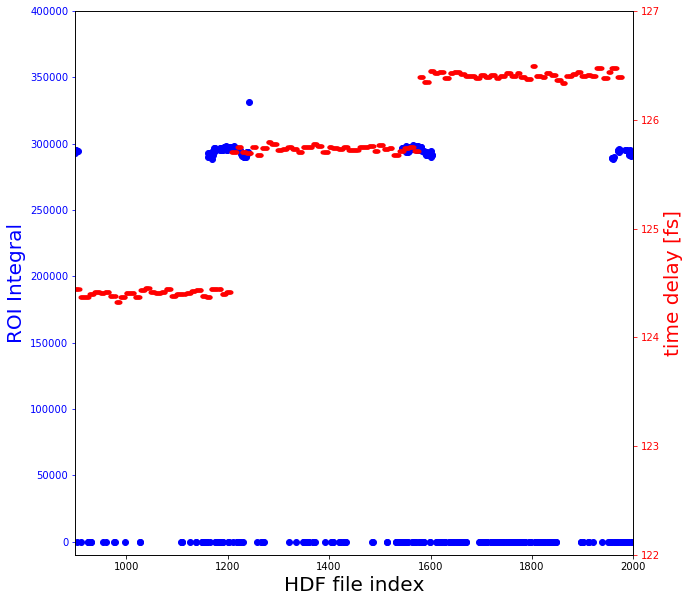

In [13]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.plot(integral,'bo')
ax1.set_xlabel('HDF file index',fontsize=20)
ax1.set_ylabel('ROI Integral', color='b', fontsize=20)
ax1.tick_params('y', colors='b')

ax1.set_ylim(-10000,400000)
ax1.set_xlim(900,2000)

ax2 = ax1.twinx()
ax2.plot(timeDelay,'r.')
ax2.set_ylabel('time delay [fs]', color='r', fontsize=20)
ax2.tick_params('y', colors='r')

ax2.set_ylim(122,127)

plt.show()

In [14]:
logicMap = (integral>1000)
res = [i for i, val in enumerate(logicMap) if val]
print('Number of blanks in the end:', len(logicMap)-res[-1])
print('Acutal Rate in dataset (without appended blanks): {0:.3f} '.format((len(res)/res[-1])))

Number of blanks in the end: 833
Acutal Rate in dataset (without appended blanks): 0.729 


# Example - Single Image

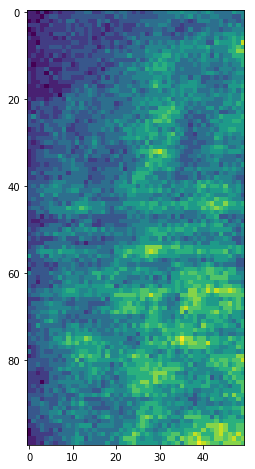

In [15]:
exampleImg=img[1300][400:500, 250:300]

plt.figure(figsize=(16,8))
plt.imshow(exampleImg)
plt.show()

In [16]:
def extractProfileLine(integrateImage):
    startSum = int(integrateImage.shape[1]/2)-20
    endSum = int(integrateImage.shape[1]/2)+20
    return np.sum(integrateImage[:,startSum:endSum], axis=1)

def calcVisibility(profileLine):
    maxs = np.max(profileLine)
    mins = np.min(profileLine)
    return (maxs-mins)/(maxs+mins)

number of profile lines in 1st delay step: 498


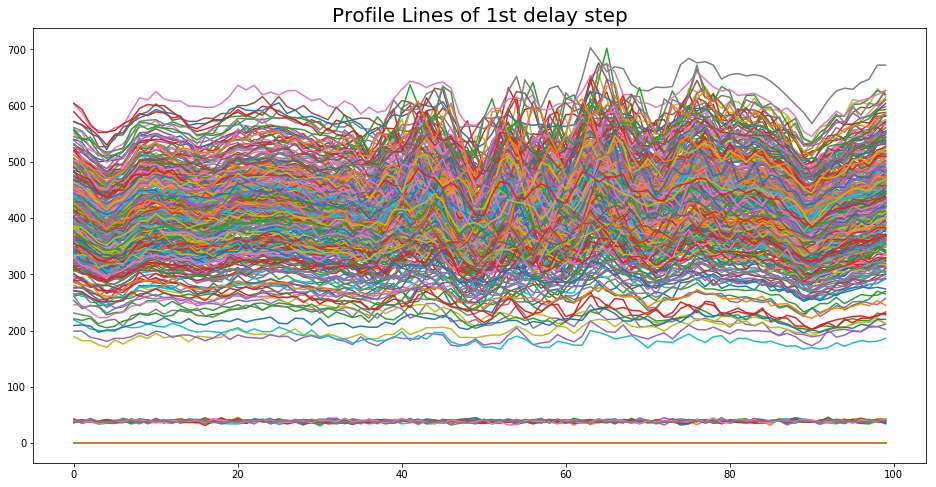

In [17]:
profileLines1DelayStep = np.asarray([extractProfileLine(img[index][400:500, 250:300]) for index in range(0,498)])

print('number of profile lines in 1st delay step:',len(profileLines1DelayStep))

plt.figure(figsize=(16,8))
[plt.plot(profileLines1DelayStep[index]) for index in range(0,profileLines1DelayStep.shape[0])]
plt.title('Profile Lines of 1st delay step', fontsize = 20);

### again 3 Types of profile lines: empty, dark & "lit" images

## extract visibility of scan

In [18]:
def extractVisivilityofScan(firstImage, lastImage):
    profileLines = np.asarray([extractProfileLine(img[index][400:500, 250:300]) for index in range(firstImage, lastImage)])
    visibilities = np.asarray([calcVisibility(profileLines[index]) for index in range(0,profileLines.shape[0])])
    return visibilities

In [19]:
visibilities = extractVisivilityofScan(0, img.shape[0])

/software/anaconda3/5.2/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in ulong_scalars
  if __name__ == '__main__':


 eliminate images with closed shutter

In [20]:
logicMapLight = (integral>50000) 

## Plot all Visibilities of Scan
* remove all images below treshold
* plot against time delay -> jitter include

### calculate averages per delay step

In [21]:
delaySteps = np.split(visibilities,indexDelayChange)
averages = [np.nanmean(delaySteps[index]) for index in range(len(delaySteps))]
std = [np.nanstd(delaySteps[index]) for index in range(len(delaySteps))]
timeDelayForAverage = np.append(timeDelay[indexDelayChange], timeDelay[-1000])

### Plot all values (blue) and average (red)

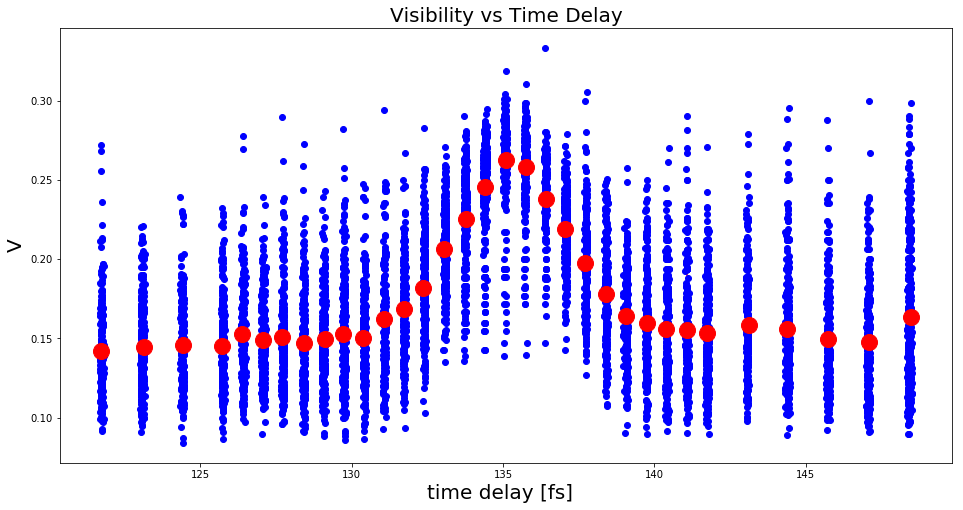

In [22]:
plt.figure(figsize=(16,8))
[plt.plot(timeDelay[index],visibilities[index],'bo') for index in range(len(visibilities)) if logicMapLight[index] == True]
plt.errorbar(timeDelayForAverage,averages, yerr = std, fmt='o', color='r',  markersize=16)
plt.title('Visibility vs Time Delay', fontsize = 20)
plt.xlabel('time delay [fs]  ',fontsize=20)
plt.ylabel('V', fontsize=20);

### Plot average with standard error (1x sigma)

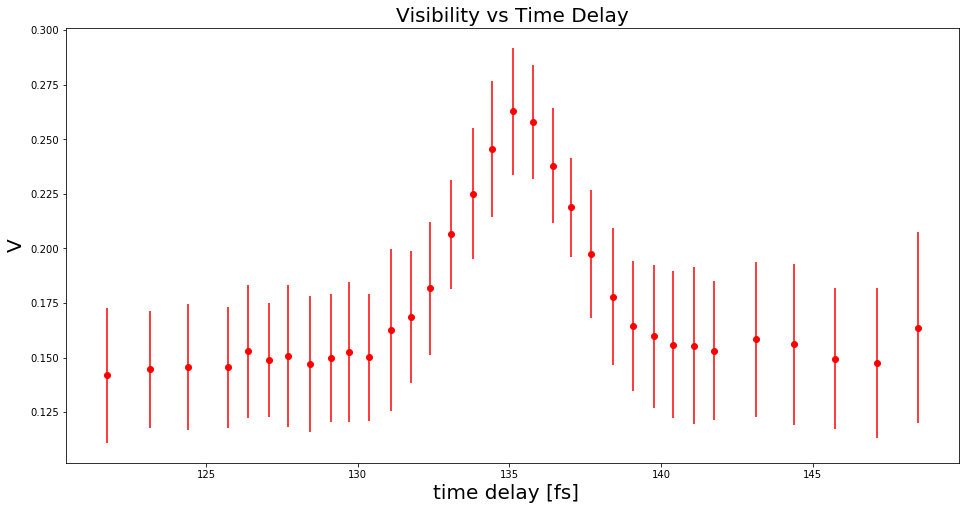

In [23]:
plt.figure(figsize=(16,8))
plt.errorbar(timeDelayForAverage,averages, yerr = std, fmt='o', color='r')
plt.title('Visibility vs Time Delay', fontsize = 20)
plt.xlabel('time delay [fs]  ',fontsize=20)
plt.ylabel('V', fontsize=20);

### Number of used pulses per delay step 

In [24]:
def countNonNaNs(array):
    return len(array)-countNaNs(array)
    
numberOfValuesPerDelay = [countNonNaNs(delaySteps[index]) for index in range(len(delaySteps))]
print(numberOfValuesPerDelay)

[348, 319, 271, 304, 238, 259, 239, 221, 247, 299, 241, 167, 225, 249, 294, 263, 324, 250, 288, 178, 304, 264, 275, 242, 269, 240, 269, 297, 212, 274, 300, 279, 569]


## Normalize Fringe Visibility on BDA GMD

In [25]:
gmdAveBdaAddr = '/FL1/Photon Diagnostic/GMD/Average energy/energy BDA (raw)'
gmdPulseResBdaAddr = '/FL1/Photon Diagnostic/GMD/Pulse resolved energy/energy BDA (raw)'

gmdAveBda = hdfFile[gmdAveBdaAddr].value
gmdPulseResBda = hdfFile[gmdPulseResBdaAddr].value

/software/anaconda3/5.2/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


### Plot averaged and pulse resoleved BDA GMD

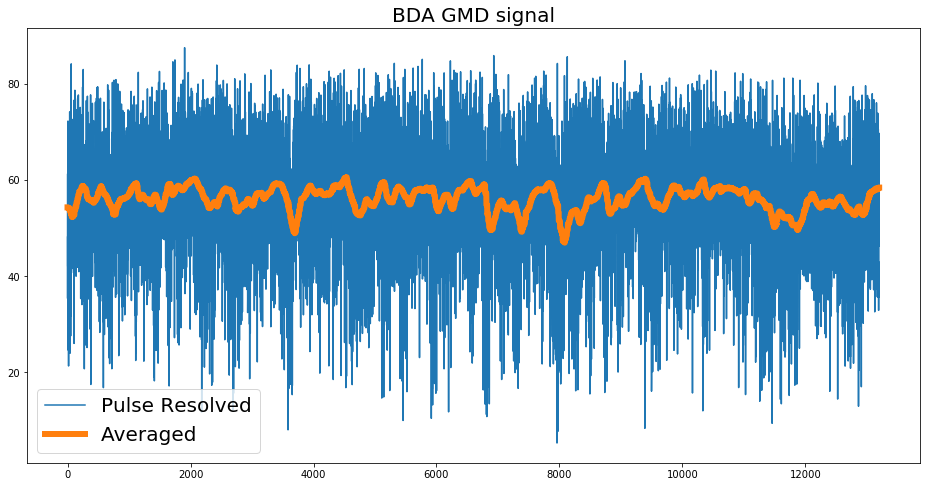

In [26]:
plt.figure(figsize=(16,8))
plt.plot(gmdPulseResBda, label = 'Pulse Resolved')
plt.plot(gmdAveBda, linewidth = 6,label = 'Averaged')
plt.legend(fontsize = 20)
plt.title('BDA GMD signal',fontsize = 20);

* hardware-like filter on electron signal (pulse resolved) to correlate with ion signal (averaged)
* shift ion signal to compensate for time delay from Keyleigh

In [27]:
def filterElectronSignal(inputValues):
    a0 = 0.00500145
    a1 = a0
    b1 = 1 - a0 - a1 
    outputValues = []
    for i in range(len(inputValues)):
        if i == 0:
            temp = inputValues[0]
        else:
            temp = a0 * inputValues[i]+a1*inputValues[i-1]+b1*outputValues[i-1]
        outputValues.append(temp)
    return outputValues

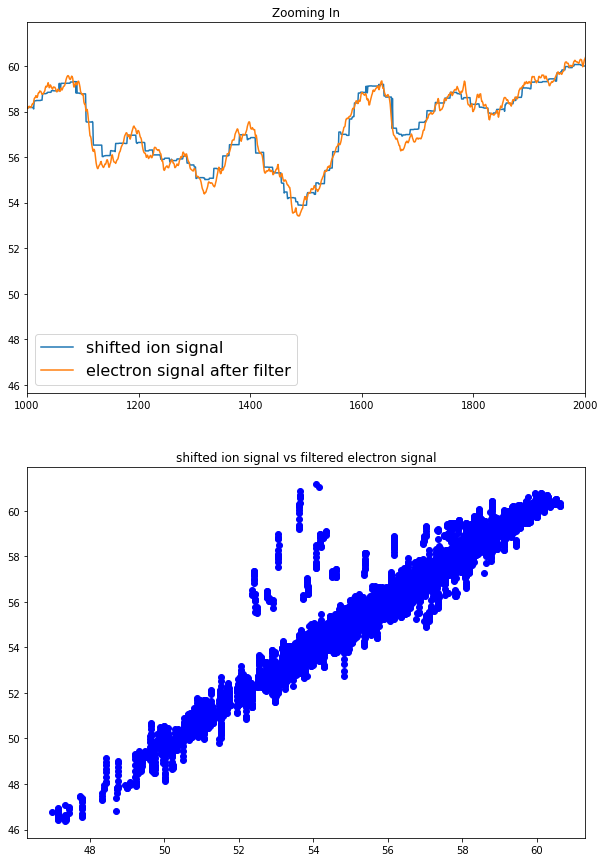

In [28]:
filteredElectronGmdBda = filterElectronSignal(np.nan_to_num(gmdPulseResBda))
shift = -34
shiftedGmdAveBda =np.roll(gmdAveBda, shift)

plt.figure(figsize=(10,15))

plt.subplot(211)
plt.plot(shiftedGmdAveBda, label = 'shifted ion signal')
plt.plot(filteredElectronGmdBda,  label = 'electron signal after filter')
plt.legend(fontsize = 16)
plt.xlim(1000,2000)
plt.title('Zooming In')

plt.subplot(212)
plt.plot(shiftedGmdAveBda, filteredElectronGmdBda, 'bo')
plt.title('shifted ion signal vs filtered electron signal')
plt.show()

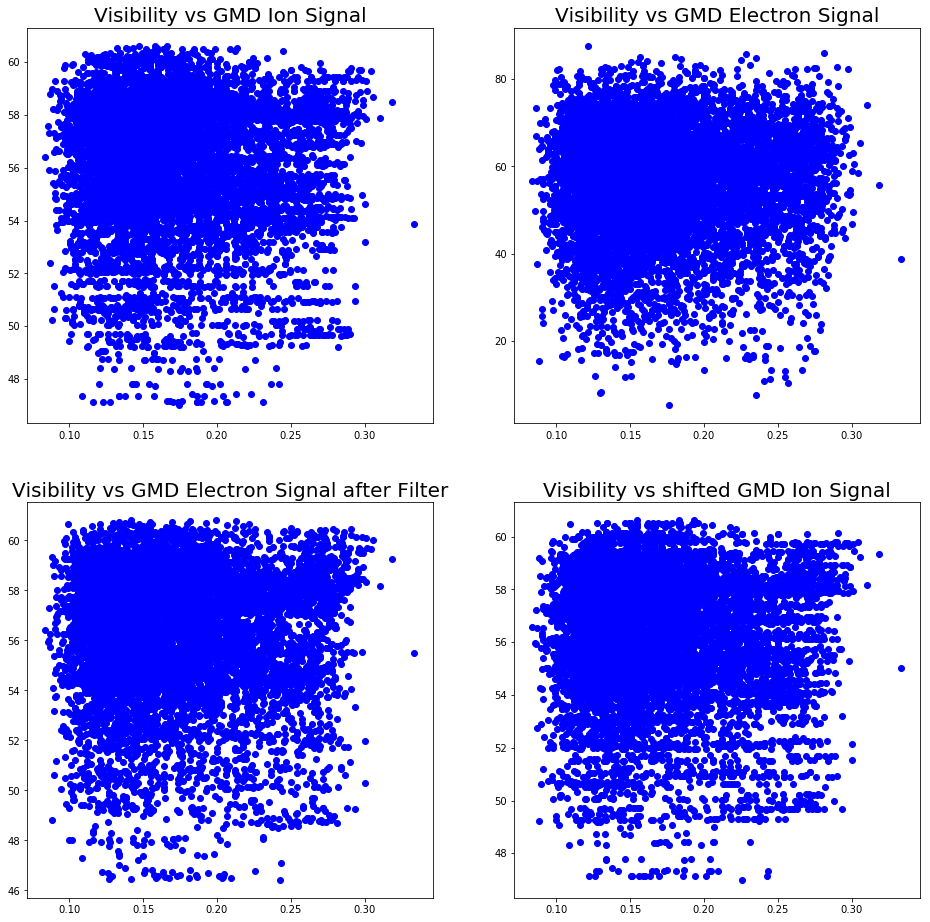

In [29]:
plt.figure(figsize=(16,16))

plt.subplot(221)
plt.plot(visibilities, gmdAveBda, 'bo')
plt.title('Visibility vs GMD Ion Signal', fontsize=20)

plt.subplot(222)
plt.plot(visibilities, gmdPulseResBda, 'bo')
plt.title('Visibility vs GMD Electron Signal', fontsize=20)

plt.subplot(223)
plt.plot(visibilities, filteredElectronGmdBda, 'bo')
plt.title('Visibility vs GMD Electron Signal after Filter', fontsize=20)

plt.subplot(224)
plt.plot(visibilities, shiftedGmdAveBda, 'bo')
plt.title('Visibility vs shifted GMD Ion Signal', fontsize=20)
plt.show()

# No Normalization possible ?

## Find Time Zero and FWHM

In [30]:
def gaus(x,a,x0,sigma,offset):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+offset

def fitParamsGaus(x, y):
    n = np.sum(y)
    mean = np.sum(y * x) / n
    sigma= np.sqrt(np.sum(y * (x - mean) ** 2) / n)
    popt,pcov = curve_fit(gaus, x, y, p0=[1, mean, sigma, 0.0])
    return popt

popt = fitParamsGaus(timeDelayForAverage , averages)
timeForGaus = np.linspace(timeDelayForAverage[0],timeDelayForAverage[-1],1000)
gausFit = gaus(timeForGaus,*popt)

In [35]:
def findFWHM(x,y, halfMax):
    d = y - halfMax
    indexes = np.where(d > 0)[0]
    return x[indexes[0]], x[indexes[-1]] 

halfMax = (np.max(gausFit)+popt[3])/2
fwhmRange = findFWHM(timeForGaus, gausFit, halfMax)
fwhm = fwhmRange[1]-fwhmRange[0]

print('time zero: {:.3f} fs'.format(popt[1]))
print('FWHM: {:.3f} fs'.format(fwhm))

time zero: 135.292 fs
FWHM: 4.365 fs


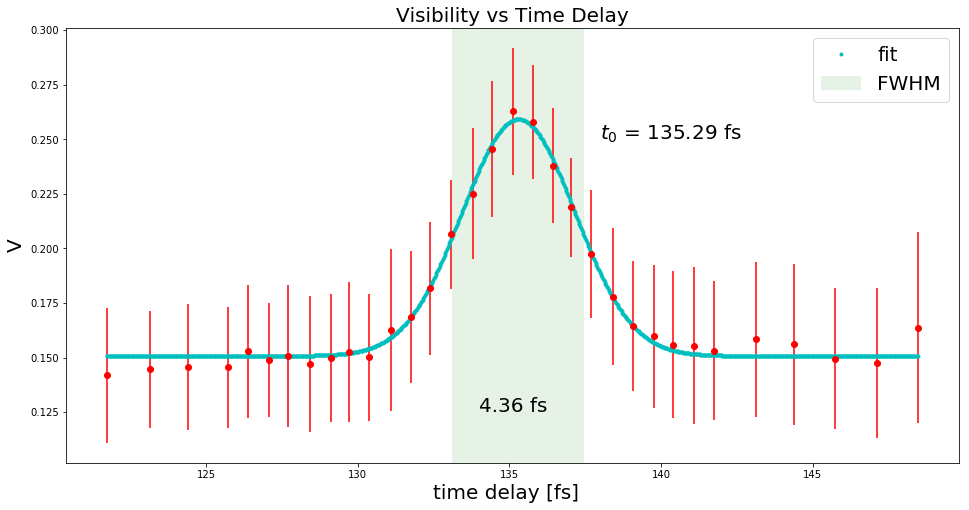

In [36]:
plt.figure(figsize=(16,8))
plt.errorbar(timeDelayForAverage,averages, yerr = std, fmt='o', color='r')
plt.plot(timeForGaus,gausFit,'c.',label='fit')
plt.axvspan(fwhmRange[0], fwhmRange[1], facecolor='g', alpha=0.1, label='FWHM')
plt.title('Visibility vs Time Delay', fontsize = 20)
plt.text(138,0.250,'$t_0$ = {:.2f} fs'.format(popt[1]),fontsize=20)
plt.text(134,0.125,'{:.2f} fs'.format(fwhm),fontsize=20)
plt.legend(fontsize=20)
plt.xlabel('time delay [fs]  ',fontsize=20)
plt.ylabel('V', fontsize=20);